<center>
    <img src="datasets/logo.png" style="width:50%;"/>
</center>

# Animal Classification with 10 Categories

In this project, we use a Convolutional Neural Network (CNN) to classify images of animals into 10 categories. The following libraries are used to load, preprocess the data, build the model, and evaluate its performance:

- **PyTorch**: For building and training the model.
- **scikit-learn**: For computing metrics like the confusion matrix.
- **Matplotlib & Seaborn**: For data visualization.
- **PIL & IPython**: For image processing and display.

The dataset contains labeled images of 10 animals: butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, and squirrel.

<center>
    <img src="datasets/animals_intro.jpg" width="40%" height="40%">
</center>

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from torchvision.models import Swin_T_Weights
from torchvision.models import ConvNeXt_Base_Weights

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
from tqdm.notebook import tqdm

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.5.1+cu124


In [3]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [4]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [5]:
!nvidia-smi

Tue Dec 17 10:03:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        Off |   00000000:01:00.0  On |                  N/A |
| 30%   27C    P8             11W /  320W |     656MiB /  16376MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset Directory

This code snippet displays the number of images available for each category in the dataset.

- The DATA_DIR variable holds the path to the dataset directory.
- The datasets.ImageFolder is used to load the dataset and automatically categorize the images based on the subdirectories.
- A loop iterates over each class in the dataset, counting the number of images in the corresponding subdirectory.
- It prints the number of images found for each category (e.g., "butterfly", "dog", etc.).

This helps in verifying the dataset's structure and ensures each class is well represented in terms of image count.

In [5]:
# Define Batch Size and Directory that contains the data
BATCH_SIZE = 32
DATA_DIR = '/home/juangarzon/AI_Projects/animal_10/datasets/images'

In [6]:
# Use ImageFolder to load the dataset
dataset = datasets.ImageFolder(root=DATA_DIR)

In [7]:
# Extract class names from ImageFolder
class_names = dataset.classes

## Remove ICC Profile from Images

This code removes the ICC profile from all images in the dataset to ensure consistency and to avoid potential issues with color profiles.

- The remove_icc_profile function opens each image, removes its ICC profile, and then overwrites the original image.
- The loop iterates through each class in the dataset, processing only the images with a .png extension.
- For each image, the ICC profile is removed, and the image is saved with the same file name.

This helps to ensure that images do not contain extra metadata that may affect their loading or processing.

In [9]:
'''
# Function to remove the ICC profile
def remove_icc_profile(image_path):
    img = Image.open(image_path)
    img.save(image_path, icc_profile=None)  # Overwrite the original image

# Loop through each class and process the images
for class_idx, class_name in enumerate(dataset.classes):
    class_dir = os.path.join(DATA_DIR, class_name)
    
    # Loop through all images in the class directory
    for filename in os.listdir(class_dir):
        if filename.endswith(".png"):  # Process only PNG images
            image_path = os.path.join(class_dir, filename)
            
            # Remove the ICC profile and overwrite the original image
            remove_icc_profile(image_path)
            print(f"Processing and overwriting: {image_path}")
'''

'\n# Function to remove the ICC profile\ndef remove_icc_profile(image_path):\n    img = Image.open(image_path)\n    img.save(image_path, icc_profile=None)  # Overwrite the original image\n\n# Loop through each class and process the images\nfor class_idx, class_name in enumerate(dataset.classes):\n    class_dir = os.path.join(DATA_DIR, class_name)\n    \n    # Loop through all images in the class directory\n    for filename in os.listdir(class_dir):\n        if filename.endswith(".png"):  # Process only PNG images\n            image_path = os.path.join(class_dir, filename)\n            \n            # Remove the ICC profile and overwrite the original image\n            remove_icc_profile(image_path)\n            print(f"Processing and overwriting: {image_path}")\n'

In [8]:
# Display the number of images in each class
for class_idx, class_name in enumerate(dataset.classes):
    class_dir = os.path.join(DATA_DIR, class_name)
    num_images = sum(1 for entry in os.scandir(class_dir) if entry.is_file())
    print(f"There are {num_images} images of {class_name.lower()}s.")

There are 2112 images of butterflys.
There are 1668 images of cats.
There are 3098 images of chickens.
There are 1866 images of cows.
There are 4860 images of dogs.
There are 1446 images of elephants.
There are 2623 images of horses.
There are 1820 images of sheeps.
There are 4821 images of spiders.
There are 1862 images of squirrels.


This code snippet visualizes sample images from the dataset's categories.

- A 2x5 grid of subplots is created using plt.subplots(), where the figure size is set to 20x8 inches.
- The title of the figure is set to 'Sample Images from Each Category' to give context.
- The loop iterates through the first 10 categories in the dataset and loads the first image from each category.
- Each image is displayed in its respective subplot, with the title of the subplot indicating the category name.

This provides a quick preview of the dataset by showing sample images from each class, allowing for an initial check of the data’s quality and diversity.

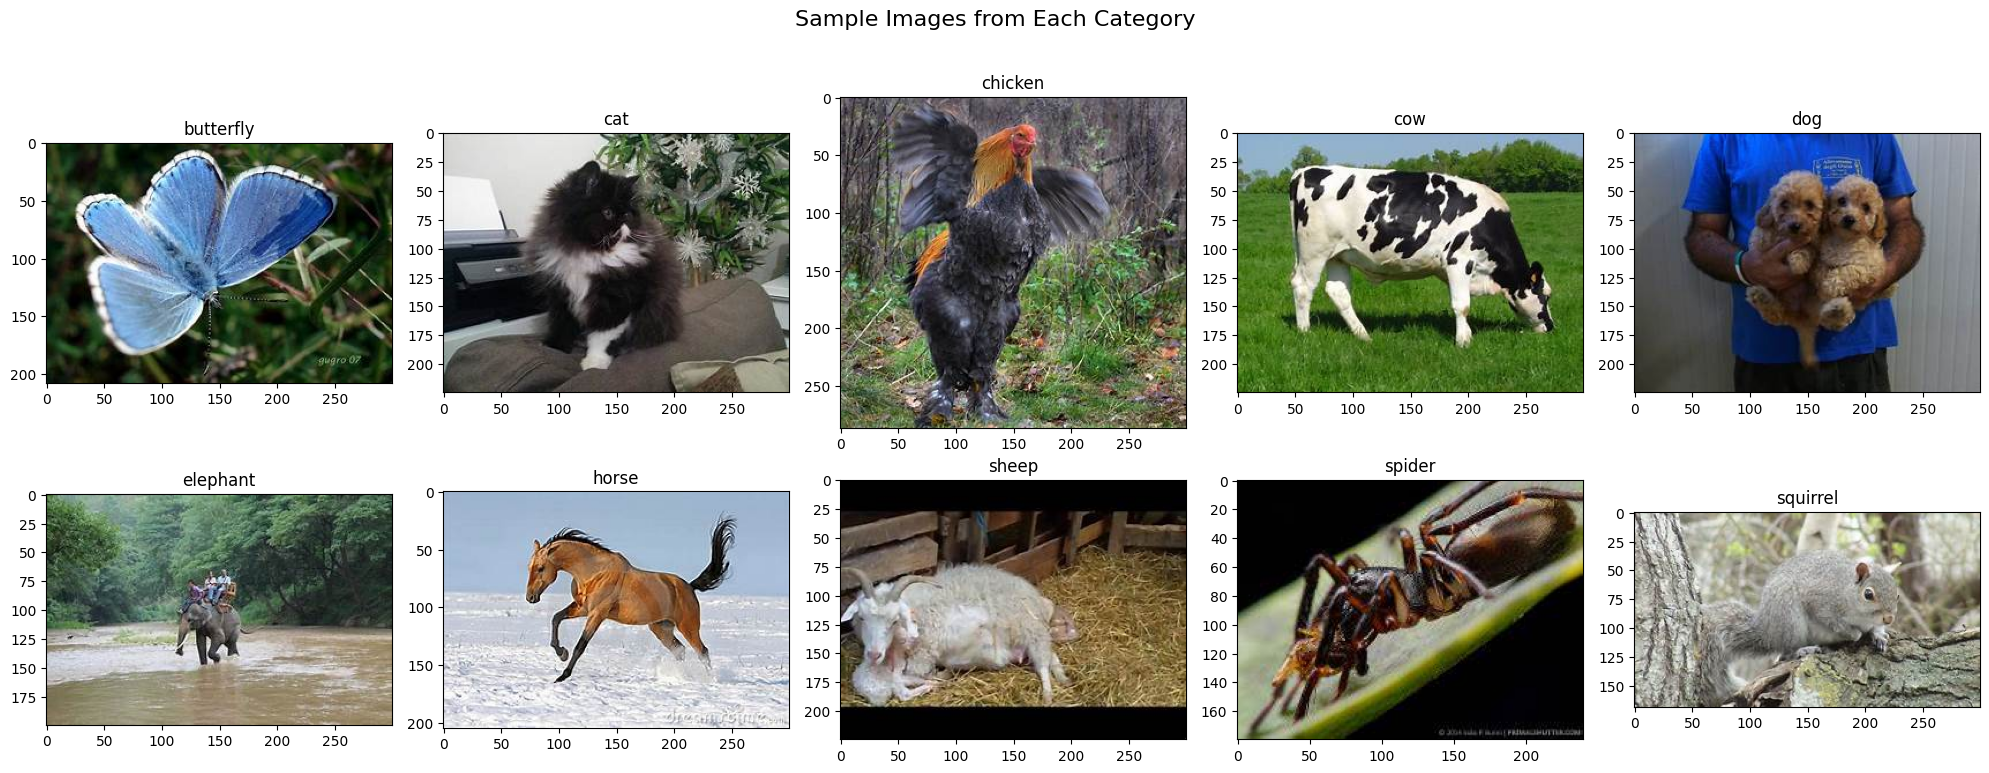

In [9]:
# Create the figure and axes for displaying sample images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns layout
fig.suptitle('Sample Images from Each Category', fontsize=16)

# Display one image from each category
categories = dataset.classes  # List of categories
for i, category in enumerate(categories[:10]):  # Limit to 10 categories
    category_dir = os.path.join(DATA_DIR, category)
    # Get all files in the category directory
    category_files = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]

    # Check if the category has any images
    if len(category_files) > 0:
        img_path = os.path.join(category_dir, category_files[0])  # Use the first image in the category
        img = Image.open(img_path)

        # Display the image with axes visible
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_title(f'{category}')
        axes[i // 5, i % 5].axis('on')  # Keep axes visible

# Adjust layout and display the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to include the title
plt.show()

## Data Augmentation Model

This function creates a data augmentation pipeline using PyTorch's transforms module. It applies random transformations like flipping, rotation, and tensor conversion to enhance the diversity of the training data and improve the model's generalization.

In [10]:
def create_augmentation_model():
    augmentation_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomRotation(180),  # Random rotation up to 180 degrees
        #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop with controlled size
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
        transforms.ToTensor()  # Convert to tensor
    ])
    return augmentation_pipeline

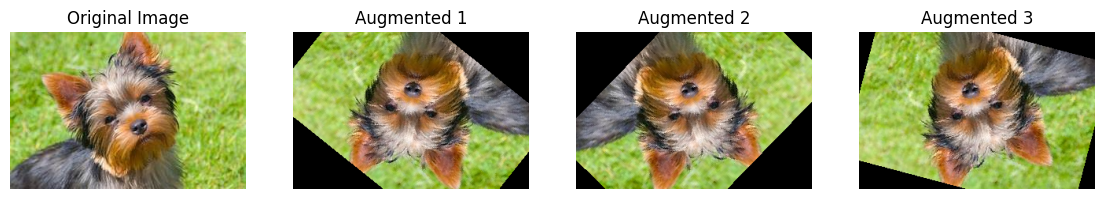

In [13]:
# Load your augmentation pipeline
data_augmentor = create_augmentation_model()

# Take a sample image from the dataset
sample_image, _ = dataset[10023]  # Assuming dataset returns (image, label)

# Store the original image
images = [sample_image]

# Apply random augmentation 3 times and store the results
for _ in range(3):
    image_aug = data_augmentor(sample_image)  # Apply augmentation directly to PIL Image
    images.append(transforms.ToPILImage()(image_aug) if isinstance(image_aug, torch.Tensor) else image_aug)

# Display the original and augmented images
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.show()

## Dataset Loading, Preprocessing, and Splitting

- Normalization: The function normalizes the images using the mean and standard deviation values typically used for models pre-trained on ImageNet.

- Transformations: Images are resized to 224x224 pixels, augmented using random transformations (e.g., horizontal flip, random rotation), and normalized.

- Dataset Splitting: The dataset is split into training and validation sets, with 85% of the data used for training and 15% for validation.

- DataLoader: The DataLoader is used to load the data in batches, with shuffling applied to the training data for better model generalization.

In [14]:
# Define the dataset and DataLoader
def train_val_datasets():
    # Define normalization parameters
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define transformations (resize images, apply augmentation, and normalize)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize all images to 224x224
        create_augmentation_model(),  # Apply augmentation
        transforms.Normalize(mean=mean, std=std)  # Normalize
    ])

    # Load the dataset using ImageFolder
    full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

    # Define the size of the validation set (15%)
    validation_size = int(0.15 * len(full_dataset))
    train_size = len(full_dataset) - validation_size

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(full_dataset, [train_size, validation_size])

    # Create DataLoader for training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

# Create the DataLoader
train_loader, val_loader = train_val_datasets()

In [15]:
print(f"Number of batches in training dataset: {len(train_loader)}")
print(f"Number of batches in validation dataset: {len(val_loader)}")

Number of batches in training dataset: 696
Number of batches in validation dataset: 123


## Calculate Class Weights

This code calculates the class weights to address class imbalance in the training dataset. The weights are based on the distribution of labels and ensure that underrepresented classes have more influence during training.

In [16]:
def calculate_class_weights(train_loader):
    # Initialize an empty list to hold all the labels
    class_labels = []

    # Iterate through the training dataset to collect all the labels
    for _, label_batch in train_loader:
        class_labels.extend(label_batch.numpy())

    # Calulate the class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

    # Create a dictionary mapping class labels to their respective weights
    class_weight_dict = dict(zip(np.unique(class_labels), class_weights))

    return class_weight_dict

# Calulate class weights
class_weights = calculate_class_weights(train_loader)

# Show the class weights
print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(1.2451035254616676), np.int64(1): np.float64(1.5614035087719298), np.int64(2): np.float64(0.8424839076107535), np.int64(3): np.float64(1.4171974522292994), np.int64(4): np.float64(0.5348557692307693), np.int64(5): np.float64(1.7929089443996777), np.int64(6): np.float64(0.9884495779653487), np.int64(7): np.float64(1.4271969211032713), np.int64(8): np.float64(0.5522462149416729), np.int64(9): np.float64(1.4020163831127914)}


## Inspect First Batch of Training Data

This code retrieves the first batch of images and labels from the training dataset to check their shapes and the maximum pixel value, providing an overview of the data structure and pixel range.

In [17]:
# Get the first batch of images and labels
data_iter = iter(train_loader)  # Create an iterator from the DataLoader
example_batch_images, example_batch_labels = next(data_iter)  # Get the first batch

# Print information about the batch
print(f"Maximum pixel value of images: {example_batch_images.max().item()}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 2.640000104904175

Shape of batch of images: torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


## CNN Model Architecture for Image Classification

### Swin Transformer Model for Transfer Learning

In this approach, a pre-trained Swin Transformer model is utilized for transfer learning to classify images into specific classes. The Swin Transformer, originally trained on ImageNet, has its weights frozen to avoid retraining. The final classification head is replaced with a new linear layer that matches the desired number of classes. During forward propagation, input images are processed through the Swin Transformer model and the newly added head to predict the correct class. This method leverages pre-learned features from ImageNet while fine-tuning the model for a custom classification task.

The Swin Transformer is an advanced vision transformer model designed to efficiently capture both local and global information in images. It combines the hierarchical feature representation of convolutional neural networks (CNNs) with the ability of transformers to model long-range dependencies. The Swin Transformer introduces a novel mechanism called "shifted windows," which divides the image into smaller, non-overlapping windows and applies self-attention within these windows. This approach reduces computational complexity while still allowing the model to capture fine-grained details. To ensure that the model can also capture global context, the windows are shifted in subsequent layers, enabling interactions between different parts of the image. This unique architecture allows the Swin Transformer to achieve superior performance in various image classification tasks, especially on complex datasets.

<center>
    <img src="datasets/Swin_Transformer.png" width="60%" height="60%">
</center>

In [18]:
num_classes = 10  # Change this to the number of classes in your dataset

In [19]:
class SwinTransformerTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(SwinTransformerTransferLearning, self).__init__()

        # Load the pre-trained Swin Transformer model on ImageNet
        self.base_model = models.swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

        # Freeze the base model parameters to avoid retraining them
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the classifier head for transfer learning
        # Get the input features of the original head (the final classifier layer)
        in_features = self.base_model.head.in_features
        # Set a new fully connected layer with the number of desired output classes
        self.base_model.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Forward pass through the base model
        x = self.base_model(x)
        return x

# Instantiate the model
model1 = SwinTransformerTransferLearning(num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /home/juangarzon/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:05<00:00, 20.2MB/s] 


In [20]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

SwinTransformerTransferLearning(
  (base_model): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (4

In [21]:
# Print the model summary
summary(model1, input_size=(BATCH_SIZE, 3, 224, 224))  # Adjusted to 3 channels and 224x224 input size

Layer (type:depth-idx)                                  Output Shape              Param #
SwinTransformerTransferLearning                         [32, 10]                  --
├─SwinTransformer: 1-1                                  [32, 10]                  --
│    └─Sequential: 2-1                                  [32, 7, 7, 768]           --
│    │    └─Sequential: 3-1                             [32, 56, 56, 96]          (4,896)
│    │    └─Sequential: 3-2                             [32, 56, 56, 96]          (224,694)
│    │    └─PatchMerging: 3-3                           [32, 28, 28, 192]         (74,496)
│    │    └─Sequential: 3-4                             [32, 28, 28, 192]         (891,756)
│    │    └─PatchMerging: 3-5                           [32, 14, 14, 384]         (296,448)
│    │    └─Sequential: 3-6                             [32, 14, 14, 384]         (10,658,952)
│    │    └─PatchMerging: 3-7                           [32, 7, 7, 768]           (1,182,720)
│    │   

## Code Implementation (EarlyStopping class)

The provided code defines the EarlyStopping class, which is used during training to stop the training process if the validation loss doesn't improve for a given number of epochs (i.e., patience). Here is the corrected explanation for the code:

1. **__init__** method: Initializes the EarlyStopping object, setting the patience parameter (the number of epochs to wait for improvement before stopping) and whether to restore the best model weights after early stopping (restore_best_weights).
2. **__call__** method: This method is invoked during training after each epoch. It compares the current validation loss (val_loss) with the best validation loss observed. If there is an improvement, it resets the counter and updates the best loss. If the validation loss does not improve for a number of epochs greater than or equal to patience, it triggers early stopping by returning True and restoring the best model weights if required.

In [22]:
# Define the early stopping class
class EarlyStopping:
    def __init__(self, patience=10, restore_best_weights=True):
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.best_weights = None
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping triggered after {self.patience} epochs without improvement.")
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        return False

##  Model Training Setup

This section defines the key settings and components for training the model:

- Optimizer: Utilizes the Adam optimizer with a predefined learning rate for efficient training.

- Loss Function: Employs cross-entropy loss with class weights to tackle class imbalance in the dataset.

- Learning Rate Scheduler: Dynamically adjusts the learning rate when the validation loss plateaus, helping the model converge.

- TensorBoard: Logs training metrics for easy visualization and monitoring of the model's progress.

- Early Stopping: Prevents overfitting by halting training if the validation loss does not improve after a set number of epochs.

In [23]:
# Hyperparameters and Settings
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005

In [24]:
# Define the optimizer
optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

# Define the loss function with class weights
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# Set up the TensorBoard writer
writer1 = SummaryWriter(log_dir='logs/fit/SwinTransformer_model')

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


## Model Training and Evaluation Loop

This section outlines the training and evaluation loop, including mixed precision training and tracking of key metrics:

- Training Phase: The model is trained for a specified number of epochs. During each epoch, the model performs a forward pass, computes the loss, and updates the weights using backpropagation with gradient scaling for mixed precision (FP16). The training loss and accuracy are calculated and logged.

- Validation Phase: After each training epoch, the model is evaluated on a validation set without gradient computation. Validation loss and accuracy are tracked and compared with training results to monitor performance.

- Metrics Logging: Training and validation losses and accuracies are logged to TensorBoard for visualization.

- Progress Bars: Training and validation progress are displayed using progress bars to provide real-time updates during each epoch.

- Learning Rate Adjustment and Early Stopping: The learning rate is adjusted if the validation loss plateaus, and training stops early if no improvement is observed after several epochs.

- Final Output: Results for each epoch, including loss and accuracy, are printed for tracking model progress.

In [25]:
# Lists to store training and validation accuracies and losses
train_acc1 = []
val_acc1 = []
train_loss_list1 = []
val_loss_list1 = []

In [26]:
# Training loop with tqdm progress bar for each epoch
for epoch in tqdm(range(NUM_EPOCHS), desc='Epochs'):
    # Epoch training phase
    model1.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Create progress bar for training epoch
    epoch_desc = f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"
    train_loader_tqdm = tqdm(train_loader, desc=epoch_desc, leave=False)

    for inputs, targets in train_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Clear gradients from previous step

        # Forward pass
        outputs = model1(inputs)
        loss = criterion(outputs, targets)  # Compute loss

        # Backpropagate
        loss.backward()
        optimizer.step()  # Update model weights

        # Accumulate loss and correct predictions
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class labels
        total += targets.size(0)  # Total number of samples
        correct += (predicted == targets).sum().item()  # Correct predictions

    # Compute average training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model1.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    epoch_desc = f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"  # Description for validation
    val_loader_tqdm = tqdm(val_loader, desc=epoch_desc, leave=False)

    with torch.no_grad():  # No gradient calculation during validation
        for inputs, targets in val_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
            outputs = model1(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item()  # Accumulate validation loss

            _, predicted = torch.max(outputs.data, 1)  # Get predicted class labels
            total += targets.size(0)  # Total number of samples
            correct += (predicted == targets).sum().item()  # Correct predictions

    # Compute average validation loss and accuracy for the epoch
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    # Log metrics to TensorBoard
    writer1.add_scalar('Loss/train', train_loss, epoch)
    writer1.add_scalar('Loss/val', val_loss, epoch)
    writer1.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer1.add_scalar('Accuracy/val', val_accuracy, epoch)

    # Append the accuracies and losses to the lists
    train_acc1.append(train_accuracy)
    val_acc1.append(val_accuracy)
    train_loss_list1.append(train_loss)
    val_loss_list1.append(val_loss)

    # Step the reduce learning rate on plateau scheduler
    reduce_lr.step(val_loss)

    # Check for early stopping
    if early_stopping(val_loss, model1):
        break

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Accuracy: {val_accuracy:.2f}%, "
          f"Learning Rate: {optimizer.param_groups[0]['lr']:.4f}")

# Close the TensorBoard writer after training is complete
writer1.close()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.4697, Val Loss: 0.1851, Train Accuracy: 89.98%, Val Accuracy: 95.29%, Learning Rate: 0.0005


Epoch 2/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.2265, Val Loss: 0.1607, Train Accuracy: 93.67%, Val Accuracy: 95.21%, Learning Rate: 0.0005


Epoch 3/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.2052, Val Loss: 0.1488, Train Accuracy: 93.90%, Val Accuracy: 95.39%, Learning Rate: 0.0005


Epoch 4/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.1895, Val Loss: 0.1324, Train Accuracy: 94.40%, Val Accuracy: 96.26%, Learning Rate: 0.0005


Epoch 5/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.1791, Val Loss: 0.1369, Train Accuracy: 94.67%, Val Accuracy: 96.26%, Learning Rate: 0.0005


Epoch 6/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.1755, Val Loss: 0.1330, Train Accuracy: 94.71%, Val Accuracy: 95.92%, Learning Rate: 0.0005


Epoch 7/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.1692, Val Loss: 0.1358, Train Accuracy: 94.84%, Val Accuracy: 95.98%, Learning Rate: 0.0005


Epoch 8/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.1714, Val Loss: 0.1269, Train Accuracy: 94.76%, Val Accuracy: 95.85%, Learning Rate: 0.0005


Epoch 9/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.1634, Val Loss: 0.1296, Train Accuracy: 94.93%, Val Accuracy: 96.20%, Learning Rate: 0.0005


Epoch 10/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.1631, Val Loss: 0.1409, Train Accuracy: 94.88%, Val Accuracy: 96.03%, Learning Rate: 0.0005


## Training and Validation Performance Visualization

This code generates a plot to visualize the model's performance during training. It shows how accuracy and loss change for both the training and validation datasets over the epochs. Two subplots are used: one for accuracy and another for loss. This helps evaluate whether the model is improving and if it's overfitting or underfitting during the training process.

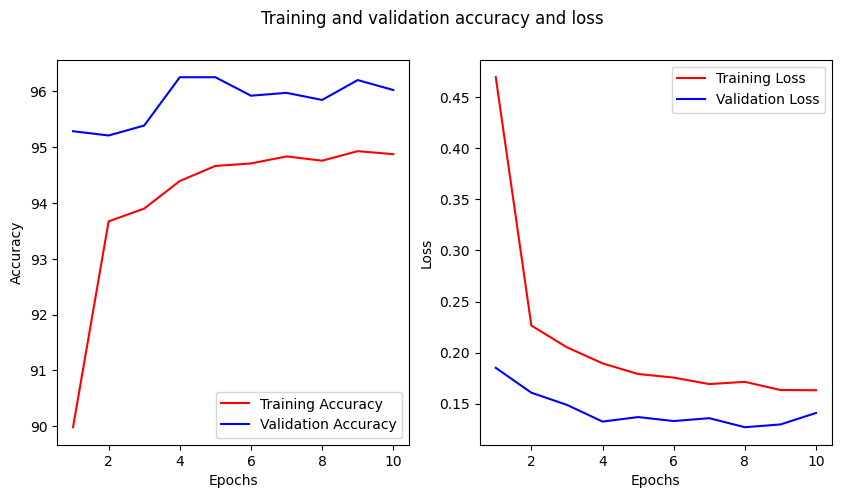

In [27]:
# Plot training and validation accuracies and losses
epochs = range(1, len(train_acc1) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy and loss')

ax[0].plot(epochs, train_acc1, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc1, 'b', label='Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss_list1, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss_list1, 'b', label='Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

## Saving the Model

This code saves the trained model, including its architecture, weights, and optimizer state, to a file. The model is stored in the file named 'scratch.py' using the .pt format. The .pt format is beneficial because it is specifically designed for PyTorch models, ensuring compatibility and efficiency when reloading the model for inference or further training. This format is widely used for model portability and allows you to reload the model later without needing to redefine its structure.

In [28]:
# Save the complete model (architecture, weights, optimizer) to a file
torch.save(model1.state_dict(), 'models/SwinTransformer.pt')  # Save as .pt format

print("Model saved successfully.")

Model saved successfully.


## Loading the Model

In [29]:
# Load the saved model (architecture + weights)
model1.load_state_dict(torch.load('models/SwinTransformer.pt'))
print("Model loaded successfully.")

# Set the model to evaluation mode (important for inference)
model1.eval()

Model loaded successfully.


/tmp/ipykernel_6315/2225907303.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('models/SwinTransformer.pt'))


SwinTransformerTransferLearning(
  (base_model): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (4

## CNN Model Architecture for Image Classification

### ConvNeXt Model for Transfer Learning


In this approach, a pre-trained ConvNeXt model is utilized for transfer learning, adapted to classify images into 10 specific classes. The ConvNeXt model, originally trained on ImageNet, has its weights frozen to prevent retraining. The final classification head is replaced with a new linear layer that corresponds to the desired number of classes. During forward propagation, input images are processed through the ConvNeXt model and the newly added head to predict the correct class. This method enables the model to leverage pre-learned features from ImageNet while fine-tuning it for a custom classification task.

ConvNeXt is a modern convolutional neural network (CNN) architecture that builds upon the successes of Vision Transformers (ViT) while retaining the core principles of CNNs. It incorporates design improvements, such as more efficient use of convolutional layers and better feature extraction, to match or even surpass the performance of transformers on image classification tasks. By leveraging a similar design to ViT, ConvNeXt maintains the advantages of CNNs, such as scalability and ease of training, while benefiting from transformer-inspired design choices.



<center>
    <img src="datasets/convnext.png" width="60%" height="60%">
</center>

In [30]:
class ConvNeXtTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeXtTransferLearning, self).__init__()

        # Load the ConvNeXt model pre-trained on ImageNet
        self.base_model = models.convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)  # Load pre-trained weights

        # Freeze the base model parameters to avoid retraining them
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the classifier head for transfer learning
        in_features = self.base_model.classifier[2].in_features  # Get the input features of the original head
        self.base_model.classifier[2] = nn.Linear(in_features, num_classes)  # New head with desired number of classes

    def forward(self, x):
        x = self.base_model(x)
        return x

# Instantiate the model
model2 = ConvNeXtTransferLearning(num_classes=num_classes)

In [31]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

ConvNeXtTransferLearning(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
     

In [32]:
# Print the model summary
summary(model2, input_size=(BATCH_SIZE, 3, 224, 224))  # Adjusted to 3 channels and 224x224 input size

Layer (type:depth-idx)                             Output Shape              Param #
ConvNeXtTransferLearning                           [32, 10]                  --
├─ConvNeXt: 1-1                                    [32, 10]                  --
│    └─Sequential: 2-1                             [32, 1024, 7, 7]          --
│    │    └─Conv2dNormActivation: 3-1              [32, 128, 56, 56]         (6,528)
│    │    └─Sequential: 3-2                        [32, 128, 56, 56]         (415,488)
│    │    └─Sequential: 3-3                        [32, 256, 28, 28]         (131,584)
│    │    └─Sequential: 3-4                        [32, 256, 28, 28]         (1,617,408)
│    │    └─Sequential: 3-5                        [32, 512, 14, 14]         (525,312)
│    │    └─Sequential: 3-6                        [32, 512, 14, 14]         (57,424,896)
│    │    └─Sequential: 3-7                        [32, 1024, 7, 7]          (2,099,200)
│    │    └─Sequential: 3-8                        [32, 1024,

##  Model Training Setup

This section defines the key settings and components for training the model:

- Optimizer: Utilizes the Adam optimizer with a predefined learning rate for efficient training.

- Loss Function: Employs cross-entropy loss with class weights to tackle class imbalance in the dataset.

- Learning Rate Scheduler: Dynamically adjusts the learning rate when the validation loss plateaus, helping the model converge.

- TensorBoard: Logs training metrics for easy visualization and monitoring of the model's progress.

- Early Stopping: Prevents overfitting by halting training if the validation loss does not improve after a set number of epochs.

In [33]:
# Hyperparameters and Settings
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005

In [34]:
# Define the optimizer
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

# Define the loss function with class weights
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

# Set up the TensorBoard writer
writer2 = SummaryWriter(log_dir='logs/fit/ConvNeXt_model')

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [35]:
# Lists to store training and validation accuracies and losses
train_acc2 = []
val_acc2 = []
train_loss_list2 = []
val_loss_list2 = []

In [36]:
for epoch in tqdm(range(NUM_EPOCHS), desc='Epochs'):
    # Epoch training phase
    model2.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Create progress bar for training epoch
    epoch_desc = f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"
    train_loader_tqdm = tqdm(train_loader, desc=epoch_desc, leave=False)

    for inputs, targets in train_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
        optimizer.zero_grad()  # Clear gradients from previous step

        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, targets)  # Compute loss

        # Backpropagate
        loss.backward()
        optimizer.step()  # Update model weights

        # Accumulate loss and correct predictions
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class labels
        total += targets.size(0)  # Total number of samples
        correct += (predicted == targets).sum().item()  # Correct predictions

    # Compute average training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model2.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    epoch_desc = f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"  # Description for validation
    val_loader_tqdm = tqdm(val_loader, desc=epoch_desc, leave=False)

    with torch.no_grad():  # No gradient calculation during validation
        for inputs, targets in val_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to device (GPU/CPU)
            outputs = model2(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            val_loss += loss.item()  # Accumulate validation loss

            _, predicted = torch.max(outputs.data, 1)  # Get predicted class labels
            total += targets.size(0)  # Total number of samples
            correct += (predicted == targets).sum().item()  # Correct predictions

    # Compute average validation loss and accuracy for the epoch
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    # Log metrics to TensorBoard
    writer2.add_scalar('Loss/train', train_loss, epoch)
    writer2.add_scalar('Loss/val', val_loss, epoch)
    writer2.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer2.add_scalar('Accuracy/val', val_accuracy, epoch)

    # Append the accuracies and losses to the lists
    train_acc2.append(train_accuracy)
    val_acc2.append(val_accuracy)
    train_loss_list2.append(train_loss)
    val_loss_list2.append(val_loss)

    # Step the reduce learning rate on plateau scheduler
    reduce_lr.step(val_loss)

    # Check for early stopping
    if early_stopping(val_loss, model2):
        break

    # Print the results for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Accuracy: {val_accuracy:.2f}%",
          f"Learning Rate: {optimizer.param_groups[0]['lr']:.4f}")

# Close the TensorBoard writer after training is complete
writer2.close()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 0.4400, Val Loss: 0.1651, Train Accuracy: 92.03%, Val Accuracy: 96.05% Learning Rate: 0.0005


Epoch 2/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 0.1840, Val Loss: 0.1275, Train Accuracy: 95.30%, Val Accuracy: 96.41% Learning Rate: 0.0005


Epoch 3/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 0.1583, Val Loss: 0.1116, Train Accuracy: 95.70%, Val Accuracy: 96.74% Learning Rate: 0.0005


Epoch 4/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.1450, Val Loss: 0.1103, Train Accuracy: 95.97%, Val Accuracy: 96.99% Learning Rate: 0.0005


Epoch 5/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.1387, Val Loss: 0.1076, Train Accuracy: 95.99%, Val Accuracy: 96.99% Learning Rate: 0.0005


Epoch 6/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 0.1321, Val Loss: 0.0997, Train Accuracy: 96.14%, Val Accuracy: 97.12% Learning Rate: 0.0005


Epoch 7/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 0.1295, Val Loss: 0.0921, Train Accuracy: 96.24%, Val Accuracy: 97.40% Learning Rate: 0.0005


Epoch 8/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 0.1280, Val Loss: 0.0955, Train Accuracy: 96.40%, Val Accuracy: 97.38% Learning Rate: 0.0005


Epoch 9/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 0.1229, Val Loss: 0.0986, Train Accuracy: 96.41%, Val Accuracy: 97.17% Learning Rate: 0.0005


Epoch 10/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/123 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 0.1197, Val Loss: 0.0884, Train Accuracy: 96.53%, Val Accuracy: 97.66% Learning Rate: 0.0005


## Training and Validation Performance Visualization

This code generates a plot to visualize the model's performance during training. It shows how accuracy and loss change for both the training and validation datasets over the epochs. Two subplots are used: one for accuracy and another for loss. This helps evaluate whether the model is improving and if it's overfitting or underfitting during the training process.

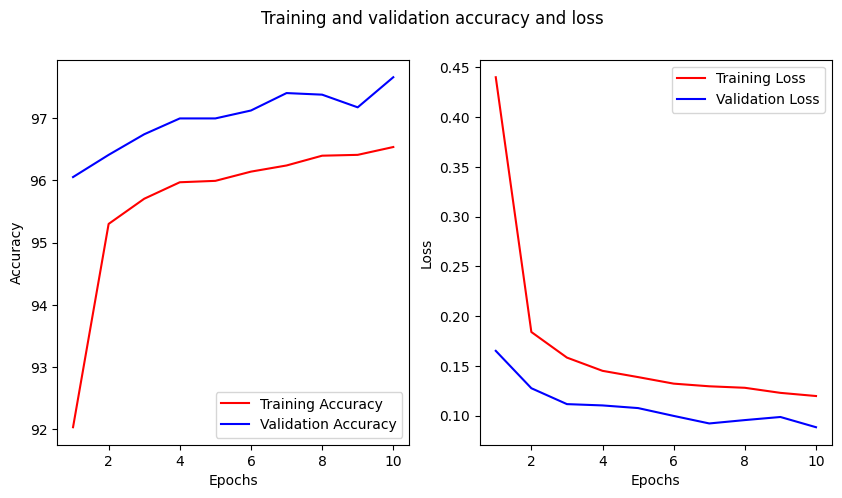

In [37]:
# Plot training and validation accuracies and losses
epochs = range(1, len(train_acc2) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy and loss')

ax[0].plot(epochs, train_acc2, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc2, 'b', label='Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss_list2, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss_list2, 'b', label='Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

## Saving the Model

This code saves the trained model, including its architecture, weights, and optimizer state, to a file. The model is stored in the file named 'resnet50.py' using the .pt format. The .pt format is beneficial because it is specifically designed for PyTorch models, ensuring compatibility and efficiency when reloading the model for inference or further training. This format is widely used for model portability and allows you to reload the model later without needing to redefine its structure.

In [38]:
# Save the complete model (architecture, weights, optimizer) to a file
torch.save(model2.state_dict(), 'models/ConvNeXt.pt')  # Save as .pt format

print("Model saved successfully.")

Model saved successfully.


## Loading the Model

In [39]:
# Load the saved model (architecture + weights)
model2.load_state_dict(torch.load('models/ConvNeXt.pt'))

print("Model loaded successfully.")

# Set the model to evaluation mode (important for inference)
model2.eval()

Model loaded successfully.


/tmp/ipykernel_6315/3994248484.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('models/ConvNeXt.pt'))


ConvNeXtTransferLearning(
  (base_model): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
     

## Generating and Visualizing the Confusion Matrix

This code generates a confusion matrix to evaluate the performance of the model by comparing the true labels (`y_true`) with the predicted labels (`y_pred`). The confusion matrix is then visualized as a heatmap using Seaborn, with a red colormap to highlight the results. The matrix's axes are labeled with the categories of the classification, and the values are annotated to show the number of correct and incorrect predictions for each class. The title of the matrix is set to 'Confusion Matrix'.

In [40]:
# Function to get predictions from the model
def get_predictions(model, dataset, device):
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU
            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get the predicted class labels

            y_true.extend(labels.cpu().numpy())  # True labels
            y_pred.extend(preds.cpu().numpy())  # Predicted labels

    return np.array(y_true), np.array(y_pred)

# Load training and validation datasets
training_dataset, validation_dataset = train_val_datasets()

# Get the true and predicted labels for model1
y_true_model1, y_pred_model1 = get_predictions(model1, validation_dataset, device)

# Get the true and predicted labels for model2
y_true_model2, y_pred_model2 = get_predictions(model2, validation_dataset, device)


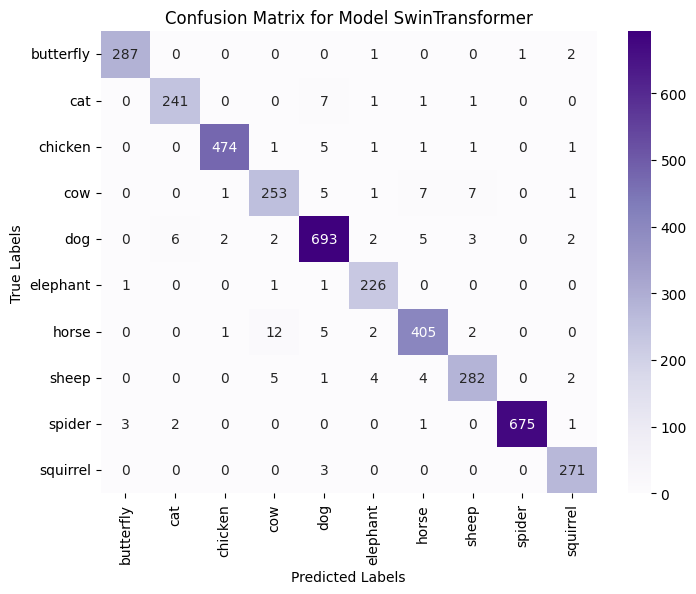

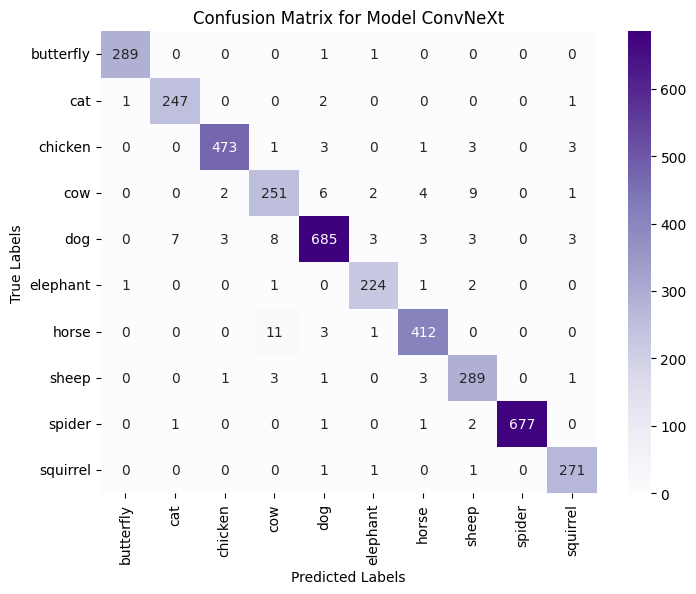

In [41]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrix for model1
plot_confusion_matrix(y_true_model1, y_pred_model1, "Model SwinTransformer", class_names)

# Plot confusion matrix for model2
plot_confusion_matrix(y_true_model2, y_pred_model2, "Model ConvNeXt", class_names)